In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from finite_state_machine import FiniteStateMachine
from visualization import plot_from_transition_matrix

from utils import  calculate_rate_distortion_curve, create_history_sequences
from complexity_measures import calculate_entropy_and_complexity, empirical_entropy_and_accuracy, calculate_sequence_probabilities, calculate_block_entropies, calculate_joint_prob_dist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define the Even Process

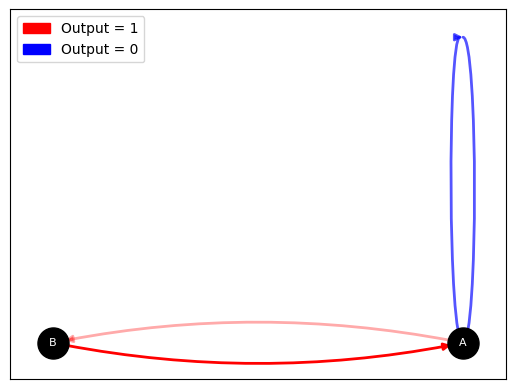

In [4]:
# Define the FSM, this is the even process
transition_function = { "A0": "A", 
                        "B1": "A", 
                        "A1": "B" }
emission_0_probs = { "A": 2/3, 
                     "B": 0 }
fsm = FiniteStateMachine(states=["A", "B"], transition_function=transition_function, emmision_0_probs=emission_0_probs)
plot_from_transition_matrix(fsm)

In [9]:
fsm.T[0]

array([[0.66666667, 0.        ],
       [0.        , 0.        ]])

## Entropy Rate, Statistical Complexity, Joint and Conditional Prob. Dists.

In [14]:
# Calculate entropy rate and statistical complexity
entropy_rate, statistical_complexity = calculate_entropy_and_complexity(fsm)
print(f"Entropy Rate: {entropy_rate}")
print(f"Statistical Complexity: {statistical_complexity}")

Entropy Rate: 0.6887218755408672
Statistical Complexity: 0.8112781244591328


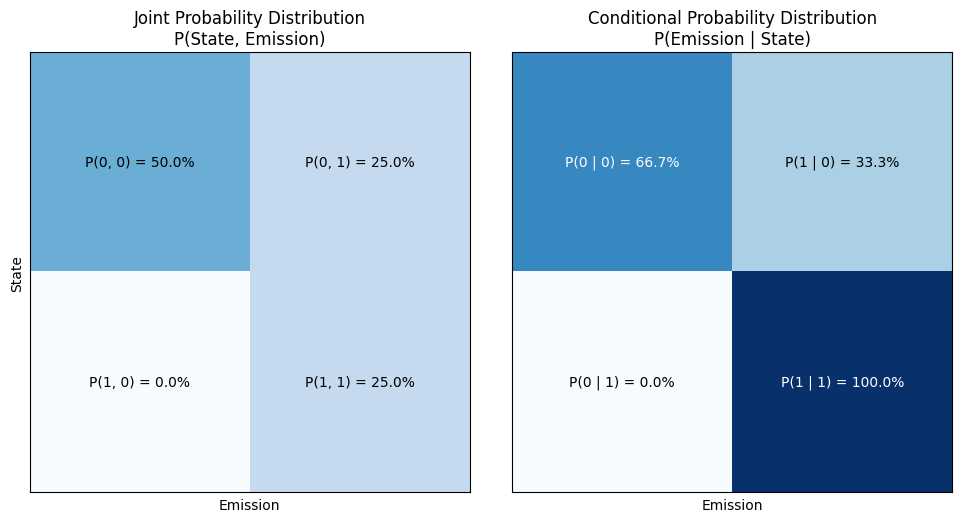

In [15]:

# Calculate joint and conditional probability distribution
joint_prob_dist = calculate_joint_prob_dist(fsm)
conditional_prob_dist = joint_prob_dist / np.sum(joint_prob_dist, axis=1, keepdims=True)

# 2 subplot figure for each prob dist
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.matshow(joint_prob_dist, cmap='Blues', vmin=0, vmax=1)
ax1.set_title('Joint Probability Distribution\nP(State, Emission)')
ax1.set_xlabel('Emission'); ax1.set_ylabel('State')
ax1.set_xticks([]); ax1.set_yticks([])
for (i, j), z in np.ndenumerate(joint_prob_dist):
    percentage = z * 100
    color = 'white' if percentage > 50 else 'black'
    ax1.text(j, i, f'P({i}, {j}) = {z * 100:.1f}%', ha='center', va='center', color=color)

ax2.matshow(conditional_prob_dist, cmap='Blues', vmin=0, vmax=1)
ax2.set_title('Conditional Probability Distribution\nP(Emission | State)')
ax2.set_xlabel('Emission')
ax2.set_xticks([]); ax2.set_yticks([])
for (i, j), z in np.ndenumerate(conditional_prob_dist):
    percentage = z * 100
    color = 'white' if percentage > 50 else 'black'
    ax2.text(j, i, f'P({j} | {i}) = {z * 100:.1f}%', ha='center', va='center', color=color)

plt.tight_layout()

## Rate Distortion Curve

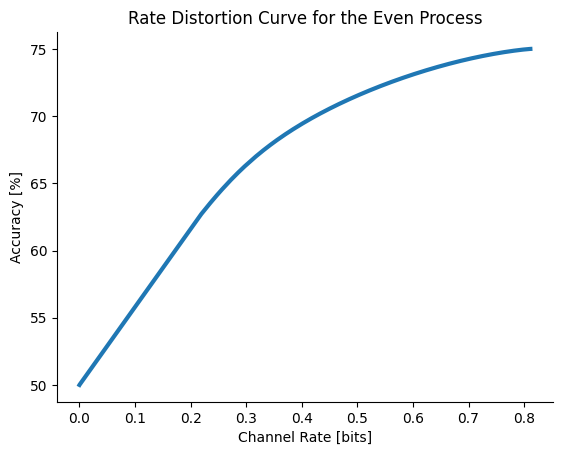

In [194]:
betas = np.linspace(0, 100, 5000)
rate, distortion = calculate_rate_distortion_curve(joint_prob_dist, betas)
plt.plot(rate, 100*distortion, lw=3)
plt.xlabel('Channel Rate [bits]'); plt.ylabel('Accuracy [%]')
plt.title('Rate Distortion Curve for the Even Process')
ax = plt.gca(); ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)

## Some Simple Testing with GLMs

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

sim_emissions, sim_states = fsm.simulate(30000)

accuracies = []
entropies = []
for hist_length in np.arange(1, 50):

    # create training, validation, and test sets
    train, val, test = create_history_sequences(sim_emissions, hist_length)
    train_hist, train_next = train[0], train[1]
    val_hist, val_next = val[0], val[1]

    model = LogisticRegression()
    model.fit(train_hist, train_next)

    # Prediction
    train_preds = model.predict(train_hist)
    val_preds = model.predict(val_hist)

    # Accuracy
    train_acc = accuracy_score(train_next, train_preds)
    val_acc = accuracy_score(val_next, val_preds)
    e, a = empirical_entropy_and_accuracy(val_next, val_preds)
    accuracies.append(a)
    entropies.append(e)

c:\Users\adamimos\anaconda3\envs\analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\adamimos\anaconda3\envs\analysis\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

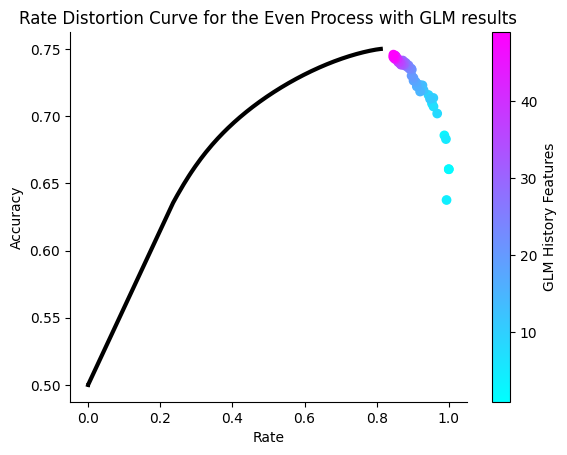

In [18]:
# plot the rate distortion curve
plt.plot(rate, distortion, lw=3, color='black')
plt.xlabel('Rate')
plt.ylabel('Accuracy')
plt.title('Rate Distortion Curve for the Even Process with GLM results')
ax = plt.gca(); ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)

# scatter of the entropies and accuracies just computed, each point with a color corresponding to the history length
sc = plt.scatter(entropies, accuracies, c=np.arange(1, 50), cmap='cool', label='History Length')
cbar = plt.colorbar(sc)
cbar.set_label('GLM History Features')

## Onto Transformers!

In [19]:
import torch
from simple_transformer import Transformer, MultilayerTransformer

In [256]:
# transformer hyperparameters
history_length = 10
d_vocab = 2
input_size = history_length
d_head = 32
n_head = 4
d_model = d_head*n_head
d_mlp = 4*d_model

sim_emissions, sim_states = fsm.simulate(1000)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

transformer = MultilayerTransformer(d_vocab, d_model, input_size, d_head, n_head, d_mlp, n_layers=2)
transformer = transformer.to(device)

train, val, test = create_history_sequences(sim_emissions, history_length)
train_hist, train_next = train[0], train[1]
val_hist, val_next = val[0], val[1]
test_hist, test_next = test[0], test[1]

# print out size of the datasets, as well s percentage, all in one line
print(f"Train: {len(train_hist)} ({len(train_hist)/len(sim_emissions):.2%}), Val: {len(val_hist)} ({len(val_hist)/len(sim_emissions):.2%}), Test: {len(test_hist)} ({len(test_hist)/len(sim_emissions):.2%})")
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import tqdm.notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

def evaluate(model, data, targets, criterion):
    model.eval()  # set the model to evaluation mode
    with torch.no_grad():  # do not compute gradients
        predictions = model(data)
        predictions = predictions[:, -1, :]
        loss = criterion(predictions, targets)
        accuracy = (predictions.argmax(dim=1) == targets).float().mean()
        entropy, accuracy_empirical = empirical_entropy_and_accuracy(np.array(targets.cpu()), predictions.argmax(dim=1).cpu().numpy())
    return loss, accuracy, entropy, accuracy_empirical

# Hyperparameters
num_epochs = 100
learning_rate = 1e-6
batch_size = 24

# Convert to torch tensors
train_hist = torch.from_numpy(train_hist).long().to(device) # batch_size, seq_len
train_next = torch.from_numpy(np.array(train_next)).long().to(device) # batch_size
val_hist = torch.from_numpy(val_hist).long().to(device)
val_next = torch.from_numpy(np.array(val_next)).long().to(device)

# Dataset and DataLoader
dataset = TensorDataset(train_hist, train_next)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=learning_rate, weight_decay=1.)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=.1, patience=50, verbose=True)

# Metrics storage
entropy_values, accuracy_values = [], []
entropy_values_train, accuracy_values_train = [], []
val_losses, train_losses = [], []

# Training loop
pbar = tqdm.tqdm(range(num_epochs), desc='Epoch', position=0)
for epoch in pbar:
    transformer.train()  # set the model to training mode

    for inputs, targets in dataloader:
        optimizer.zero_grad()  # reset gradients

        predictions = transformer(inputs)  # forward pass
        predictions = predictions[:, -1, :]  # we only care about the final prediction

        loss = criterion(predictions, targets)  # calculate loss

        loss.backward()  # backpropagation
        optimizer.step()  # update parameters

        # Evaluate on training and validation data
        val_loss, val_accuracy, val_entropy, val_accuracy_empirical = evaluate(transformer, val_hist, val_next, criterion)
        train_loss, train_accuracy, train_entropy, train_accuracy_empirical = evaluate(transformer, train_hist, train_next, criterion)
        val_losses.append(val_loss.item())
        train_losses.append(train_loss.item())
        
        # Store metrics
        entropy_values.append(val_entropy)
        accuracy_values.append(val_accuracy_empirical)
        entropy_values_train.append(train_entropy)
        accuracy_values_train.append(train_accuracy_empirical)

        # Update the learning rate
        # scheduler.step(val_accuracy)

        # set postfix
        pbar.set_postfix({'loss': loss.item(), 'accuracy': train_accuracy.item(), 'val_accuracy': val_accuracy.item(), 'val_loss': val_loss.item()})


Train: 490 (49.00%), Val: 190 (19.00%), Test: 290 (29.00%)


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

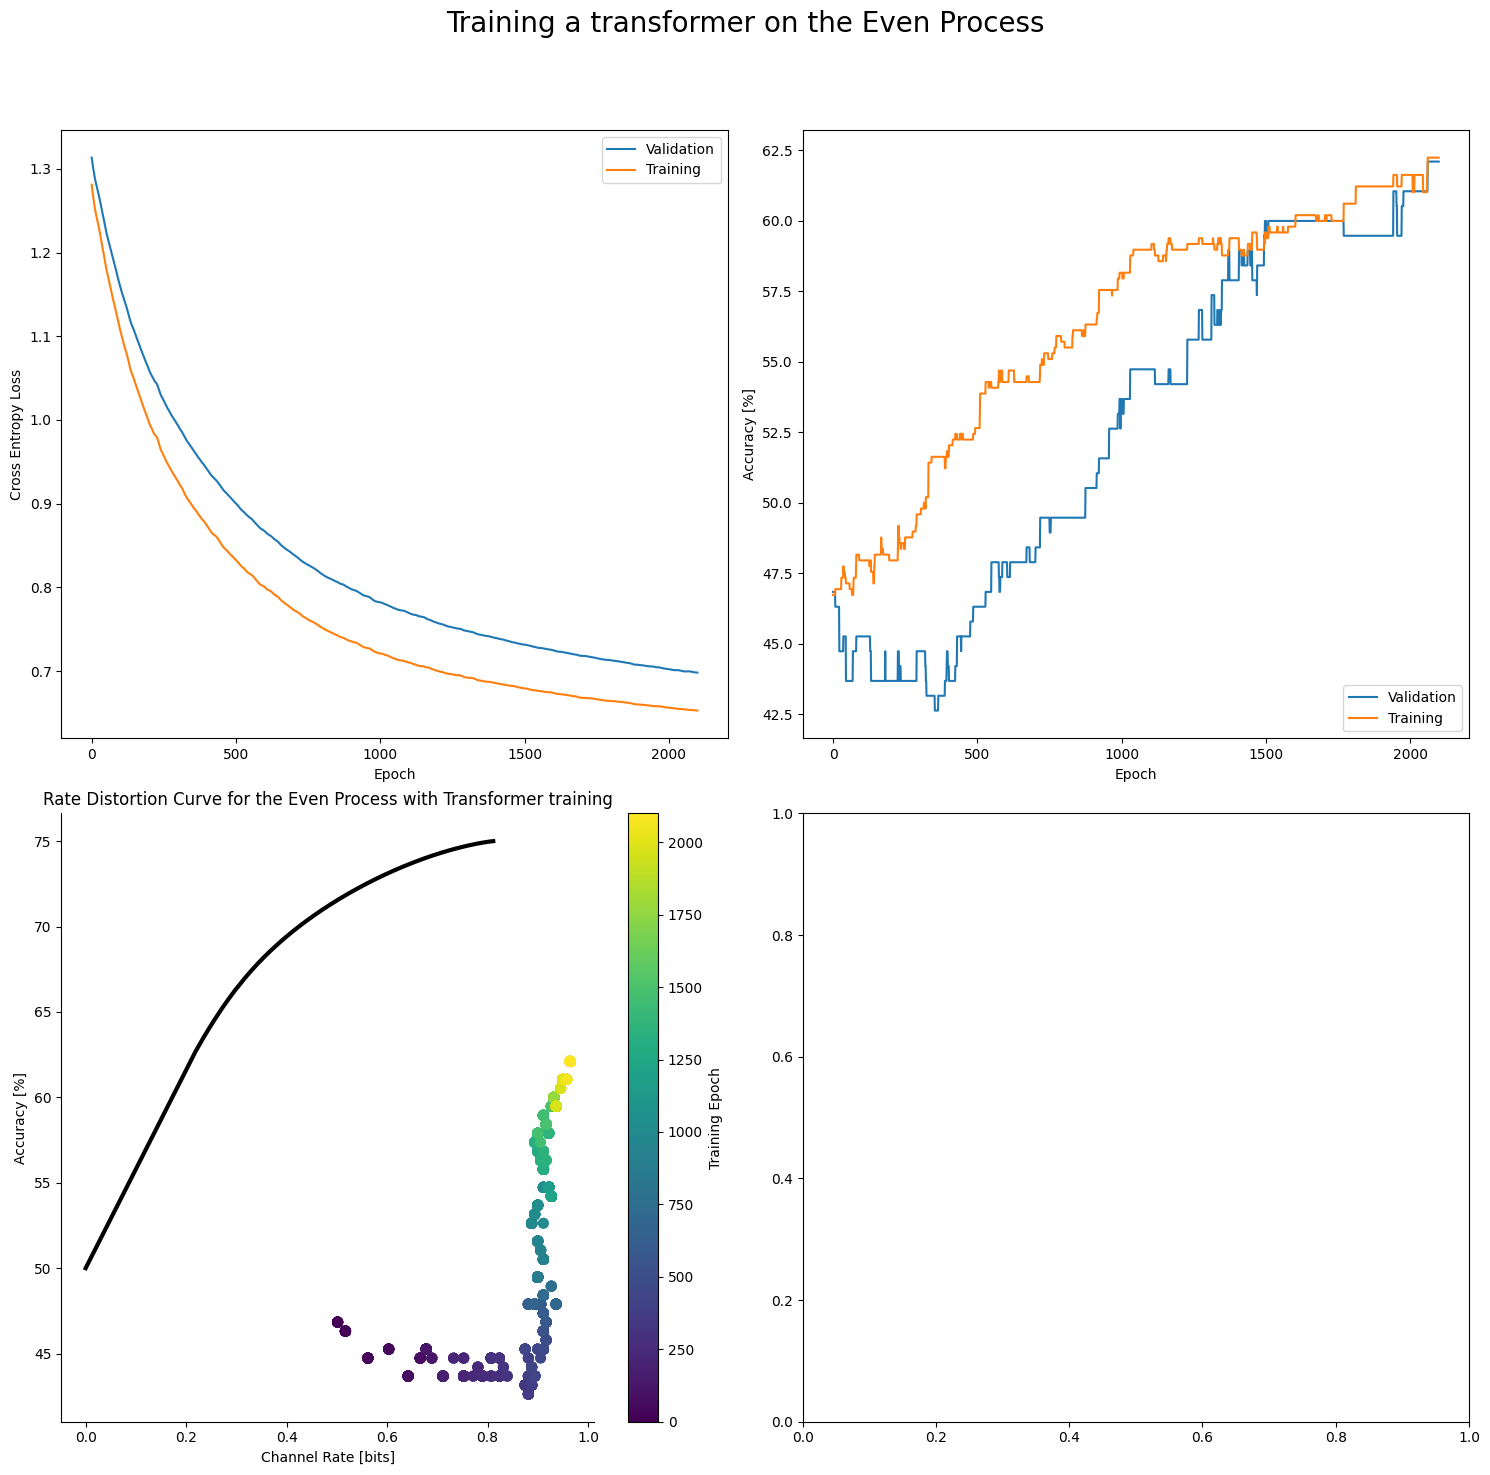

In [259]:
figure, axs = plt.subplots(2, 2, figsize=(15, 15))
figure.suptitle('Training a transformer on the Even Process', fontsize=20)
n_epochs = len(val_losses)

# Cross Entropy Loss plot
axs[0, 0].plot(np.arange(0,n_epochs), val_losses[:n_epochs], linewidth=1.5, label='Validation')
axs[0, 0].plot(np.arange(0,n_epochs), train_losses[:n_epochs], linewidth=1.5, label='Training')
axs[0, 0].legend(loc='upper right')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Cross Entropy Loss')

# Accuracy plot
axs[0, 1].plot(np.arange(0,n_epochs), 100*np.array(accuracy_values)[:n_epochs], linewidth=1.5, label='Validation')
axs[0, 1].plot(np.arange(0,n_epochs), 100*np.array(accuracy_values_train)[:n_epochs], linewidth=1.5, label='Training')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Accuracy [%]')
axs[0, 1].legend(loc='lower right')

# Rate Distortion Curve
axs[1, 0].plot(rate, 100*distortion, lw=3, color='black')
axs[1, 0].set_xlabel('Channel Rate [bits]')
axs[1, 0].set_ylabel('Accuracy [%]')
axs[1, 0].set_title('Rate Distortion Curve for the Even Process with Transformer training')
axs[1, 0].spines['top'].set_visible(False)
axs[1, 0].spines['right'].set_visible(False)

# Scatter of the entropies and accuracies
sc = axs[1, 0].scatter(entropy_values[:n_epochs], 100*np.array(accuracy_values[:n_epochs]), c=np.arange(0,n_epochs), cmap='viridis', s=50)
cbar = figure.colorbar(sc, ax=axs[1, 0])
cbar.set_label('Training Epoch')

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # create some space below the suptitle
plt.show()


[[0.5947074  0.4052926 ]
 [0.38715634 0.6128437 ]
 [0.59323597 0.4067641 ]
 [0.38597754 0.6140225 ]
 [0.5944017  0.40559825]
 [0.3865361  0.61346394]
 [0.5924544  0.40754566]
 [0.38472578 0.6152742 ]
 [0.59416986 0.40583017]
 [0.38674513 0.6132549 ]
 [0.5923487  0.40765134]
 [0.38505292 0.614947  ]
 [0.5934698  0.4065302 ]
 [0.38554475 0.6144552 ]
 [0.59116644 0.40883356]
 [0.3831697  0.61683035]]


tensor([[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 1, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 1],
        [0, 1, 1, 0],
        [0, 1, 1, 1],
        [1, 0, 0, 0],
        [1, 0, 0, 1],
        [1, 0, 1, 0],
        [1, 0, 1, 1],
        [1, 1, 0, 0],
        [1, 1, 0, 1],
        [1, 1, 1, 0],
        [1, 1, 1, 1]])

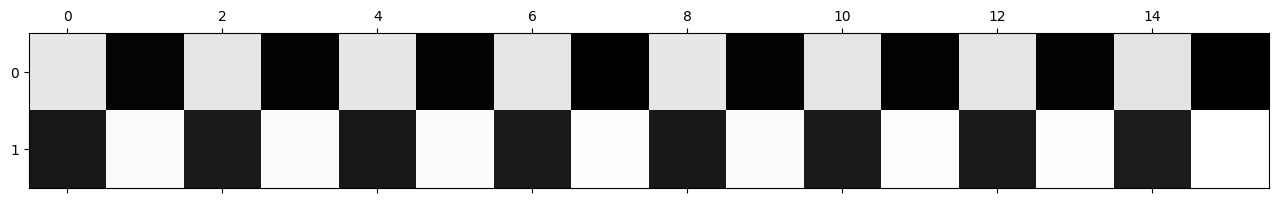

In [22]:
# get all possible 3 bit strings
import itertools
all_histories = torch.tensor(list(itertools.product([0,1], repeat=history_length))).long()

probs = transformer.predict_probs(all_histories)[:, -1, :].detach().numpy()
print(probs)
plt.matshow(probs.T, cmap='gray')
all_histories

{0: 0, 1: 1.0, 2: 1.688721875540867, 3: 2.5786968760216378, 4: 3.267418751562505, 5: 4.111278474345626, 6: 4.800000349886494, 7: 5.56978599859554, 8: 6.258507874136408, 9: 6.984034726540257, 10: 7.672756602081124, 11: 8.377008042956403, 12: 9.06572991849727, 13: 9.760715395720748, 14: 10.449437271261614, 15: 11.140609373998178, 16: 11.829331249539043, 17: 12.518990654134527, 18: 13.207712529675396, 19: 13.89678717711982, 20: 14.585509052660687}


Text(0, 0.5, 'Entropy [bits]')

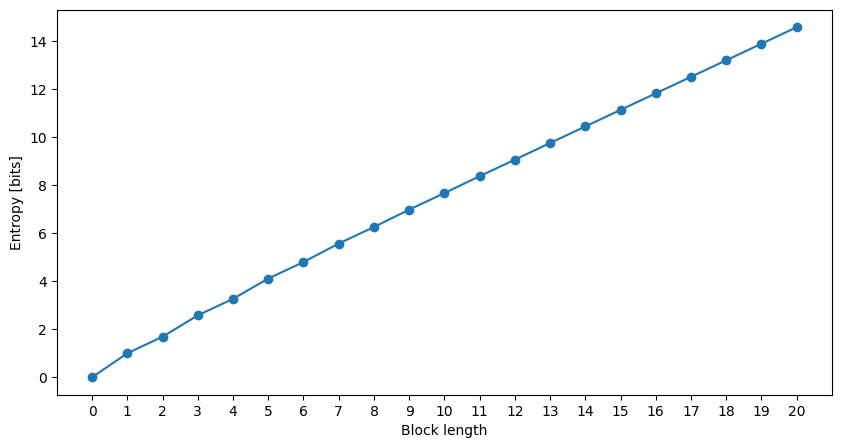

In [261]:
# Test the function
sequence_probs = calculate_sequence_probabilities(fsm, 20)
entropies = calculate_block_entropies(sequence_probs)
print(entropies)

# plot the entropies
plt.figure(figsize=(10, 5))
plt.plot(entropies.keys(), entropies.values(), 'o-')
# x-axis shoul only have ticks at integers
plt.xticks(np.arange(min(entropies.keys()), max(entropies.keys())+1, 1.0));
plt.xlabel("Block length")
plt.ylabel("Entropy [bits]")


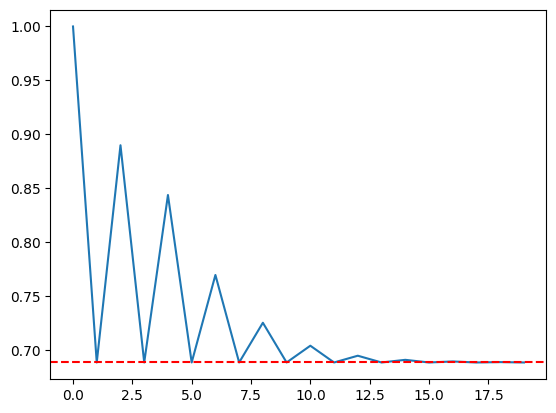

In [25]:
plt.plot(np.diff(list(entropies.values())))
# add horizontal line at entropy_Rate
plt.axhline(entropy_rate, color='r', linestyle='--')

In [68]:
from typing import Dict, List, Tuple

def create_fsm_inputs(sequence_probs: Dict[int, Dict[str, float]], N: int):
    states = list(sequence_probs[N].keys())
    emmision_0_probs = {}
    transition_function = {}

    for state in states:
        # define emissions
        zero_sequence = state[1:] + '0'
        one_sequence = state[1:] + '1'
        
        zero_prob = sequence_probs[N].get(zero_sequence, 0)
        one_prob = sequence_probs[N].get(one_sequence, 0)
        
        total_prob = zero_prob + one_prob

        if total_prob > 0:
            emmision_0_probs[state] = zero_prob / total_prob
        else:
            emmision_0_probs[state] = 0

        # define transitions
        if zero_sequence in states:
            transition_function[state + '0'] = zero_sequence
        if one_sequence in states:
            transition_function[state + '1'] = one_sequence

    return FiniteStateMachine(states=states, transition_function=transition_function, emmision_0_probs=emmision_0_probs)



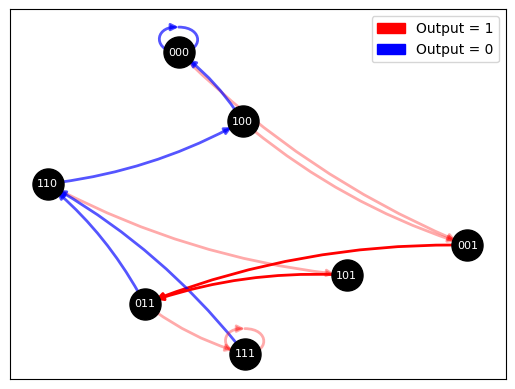

Entropy rate: 0.7513329551354915
Statistical complexity: 2.687592982667019


In [276]:
from typing import Dict, List, Tuple
from sklearn.cluster import AgglomerativeClustering

def reduce_fsm(fsm, epsilon):
    # Compute conditional prob dist
    joint_prob_dist = calculate_joint_prob_dist(fsm)
    conditional_prob_dist = joint_prob_dist/np.sum(joint_prob_dist, axis=1)[:, np.newaxis]
    print("Conditional Probability Distribution:\n", conditional_prob_dist)

    new_transition = {}
    combined_emission_0_probs = {}

    # Perform clustering
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=epsilon).fit(conditional_prob_dist)
    clusters = clustering.labels_
    print("Cluster Labels for States:\n", dict(zip(fsm.states, clusters)))

    # this is a list of the new label names for each old cluster
    cluster_labels = [chr(i+65) for i in clusters]
    print("New Cluster Labels:\n", cluster_labels)

    state_mapping = {old: new for old, new in zip(fsm.states, cluster_labels)}
    print("State Mapping from old to new:\n", state_mapping)

    for cluster in set(cluster_labels):
        
        # use the state mapping to find all keys that have the value of cluster
        old_states = [k for k, v in state_mapping.items() if v == cluster]

        old_emission_0_probs = [fsm.emmision_0_probs[s] for s in old_states]
        combined_emission_0_probs[cluster] = np.mean(old_emission_0_probs)
        print(f"For Cluster {cluster}, combined emission_0_probs: {combined_emission_0_probs[cluster]}")
        
        for output in [0, 1]:
            # we want to get the transition function
            # for each new state
            # we are in new state cluster
            key_string = cluster + str(output)

            # does fsm.transition_function[old_state + str(output)] exist?
            transition_exists = [old_state + str(output) in fsm.transition_function for old_state in old_states]

            # if all the old states have no transition, then continue
            if not any(transition_exists):
                print(f"No transition exists for old states {old_states} for output {output}")
                continue
            # if some but not all of the old states have a transition, then raise an error
            elif not all(transition_exists):
                raise ValueError("Some but not all of the old states have a transition")

            # now we need to figure out which new state we transition to, based on the old states
            # for each old state thats part of this new state, find the old state it maps to
            # then find the new state that old state maps to
            old_maps_to = [fsm.transition_function[old_state + str(output)] for old_state in old_states]
            new_maps_to = [state_mapping[old_state] for old_state in old_maps_to]
            print(f"For old states {old_states}, transition for output {output} maps to: {old_maps_to}, which correspond to new states: {new_maps_to}")
            
            # make sure new_maps_to only has 1 value
            assert len(set(new_maps_to)) == 1
            new_transition[key_string] = new_maps_to[0]

    return FiniteStateMachine(states=np.unique(cluster_labels), transition_function=new_transition, emmision_0_probs=combined_emission_0_probs)

fsm_sub = create_fsm_inputs(sequence_probs, 3)
plot_from_transition_matrix(fsm_sub, 'spring')
entropy_rate, statistical_complexity = calculate_entropy_and_complexity(fsm_sub)
print(f"Entropy rate: {entropy_rate}")
print(f"Statistical complexity: {statistical_complexity}")


In [277]:
fsm_sub_reduced = reduce_fsm(fsm_sub, 1e-10)
plot_from_transition_matrix(fsm_sub_reduced, 'spring')
entropy_rate, statistical_complexity = calculate_entropy_and_complexity(fsm_sub_reduced);
print(f"Entropy rate: {entropy_rate}")
print(f"Statistical complexity: {statistical_complexity}")


Conditional Probability Distribution:
 [[0.66666667 0.33333333]
 [0.         1.        ]
 [0.66666667 0.33333333]
 [0.66666667 0.33333333]
 [0.66666667 0.33333333]
 [0.66666667 0.33333333]
 [0.         1.        ]]
Cluster Labels for States:
 {'000': 0, '001': 1, '011': 0, '110': 0, '111': 0, '100': 0, '101': 1}
New Cluster Labels:
 ['A', 'B', 'A', 'A', 'A', 'A', 'B']
State Mapping from old to new:
 {'000': 'A', '001': 'B', '011': 'A', '110': 'A', '111': 'A', '100': 'A', '101': 'B'}
For Cluster B, combined emission_0_probs: 0.0
No transition exists for old states ['001', '101'] for output 0
For old states ['001', '101'], transition for output 1 maps to: ['011', '011'], which correspond to new states: ['A', 'A']
For Cluster A, combined emission_0_probs: 0.6666666666666666
For old states ['000', '011', '110', '111', '100'], transition for output 0 maps to: ['000', '110', '100', '110', '000'], which correspond to new states: ['A', 'A', 'A', 'A', 'A']
For old states ['000', '011', '110', '

AssertionError: 